# Preliminary Analysis

### Basic loading and type definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr
from scipy import stats



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('../Taller1/datos.xlsx')

In [4]:
df['year'] = pd.to_datetime(df['year'], format = '%Y')

In [5]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [6]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [7]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [8]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            672 non-null    datetime64[ns]
 1   Produccion      672 non-null    float64       
 2   Reservas        672 non-null    float64       
 3   PIB             672 non-null    float64       
 4   Oil Prices      672 non-null    float64       
 5   pais            672 non-null    category      
 6   log_produccion  672 non-null    float64       
 7   log_reservas    672 non-null    float64       
 8   log_pib         672 non-null    float64       
 9   log_oil_prices  672 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(8)
memory usage: 49.3 KB


### 3. Correlations

In [10]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, 0.1), xycoords=ax.transAxes)

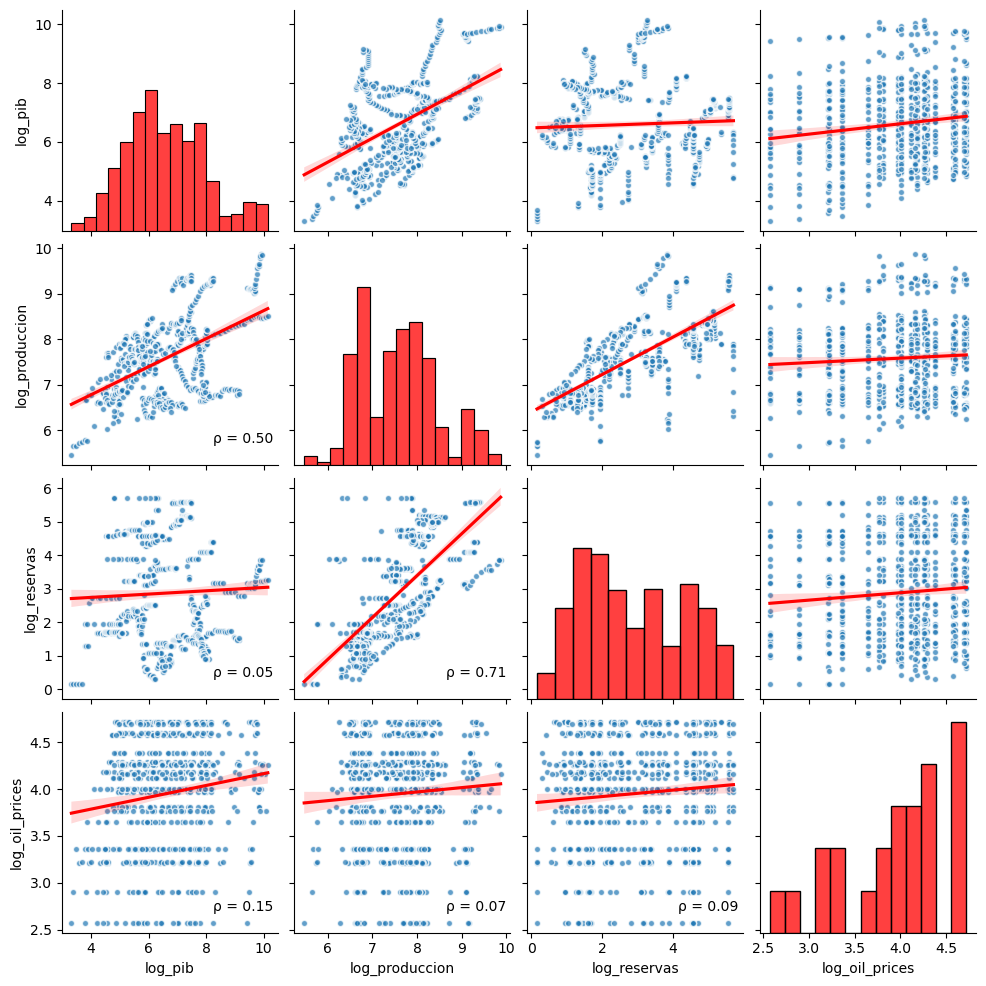

In [11]:
g = sns.pairplot(df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']], kind = "reg", diag_kind='hist', diag_kws = {'color': 'red'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{"alpha": 0.7, "s": 20, 'edgecolors': 'white'}})
g.map_lower(corrfunc)
plt.show()

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [12]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)
    fig.show()


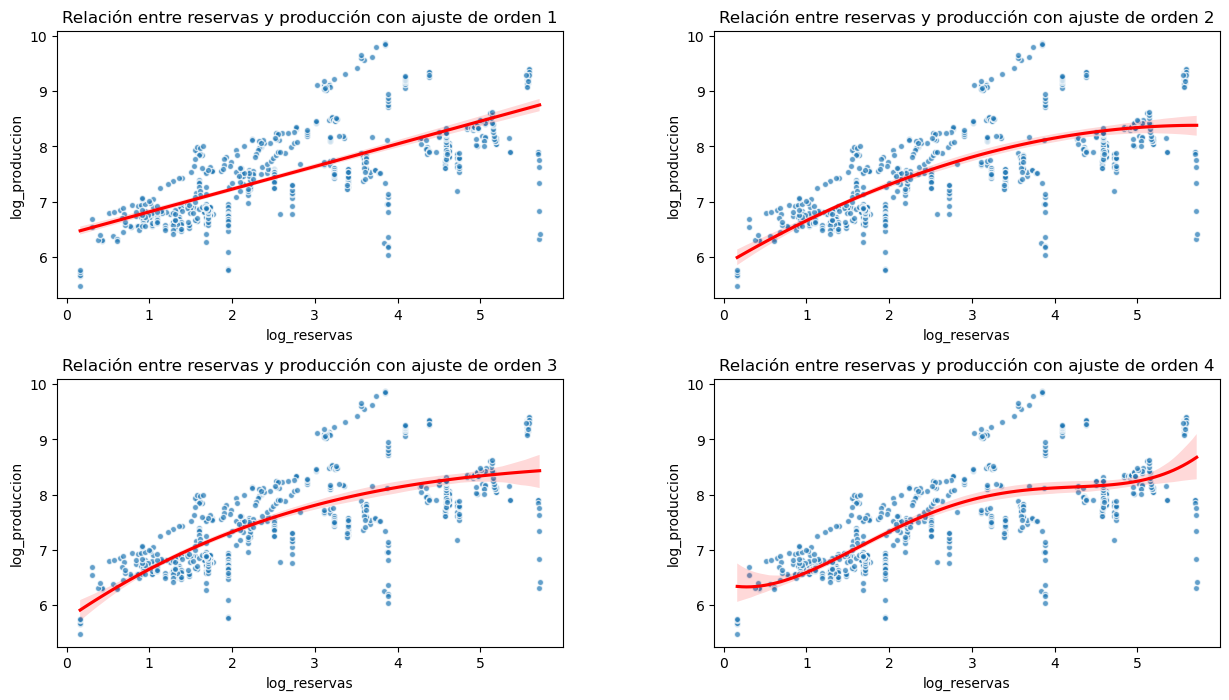

In [13]:
plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

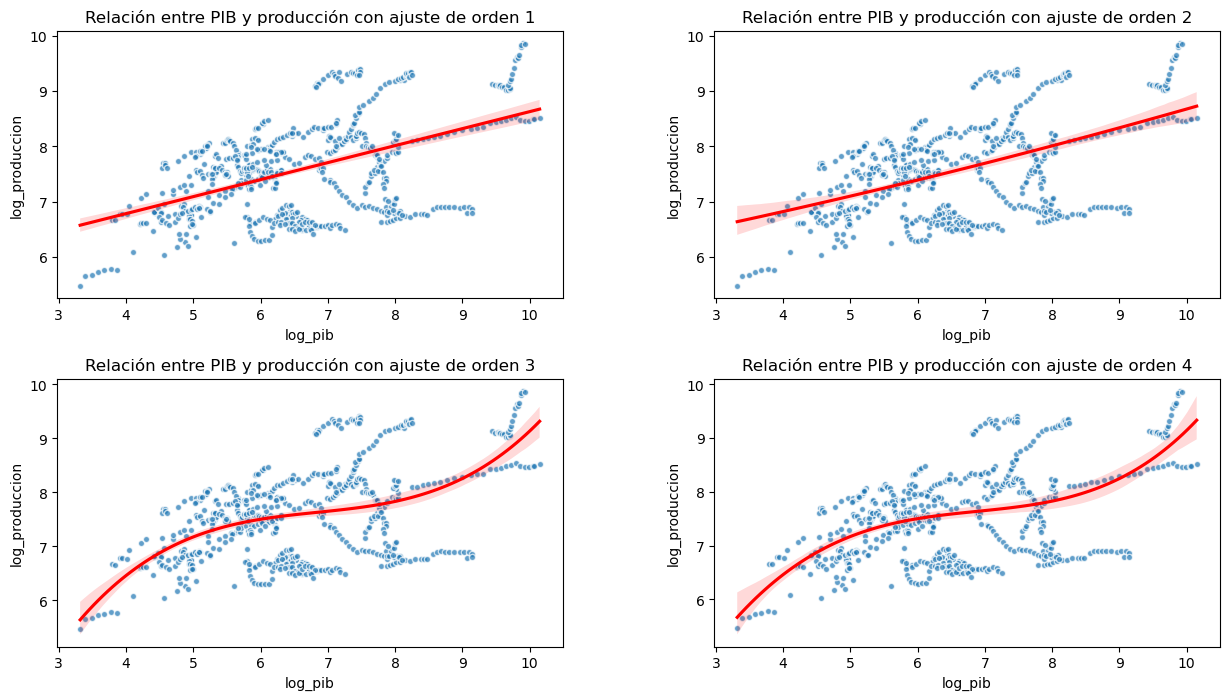

In [14]:
plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

### 5. Boxplot

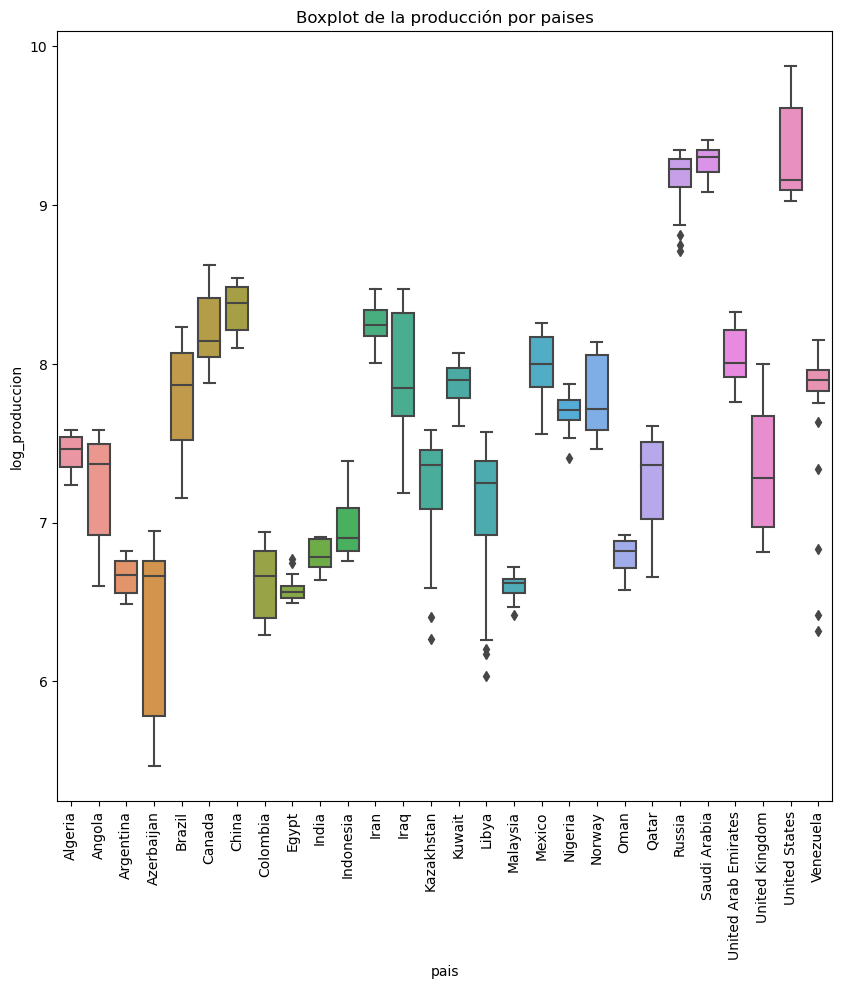

In [15]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.show()

### 6. Model Estimation

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [16]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [17]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [18]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [19]:
import statsmodels.api as sm

In [20]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     466.0
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          8.52e-188
Time:                        21:27:12   Log-Likelihood:                -366.10
No. Observations:                 644   AIC:                             742.2
Df Residuals:                     639   BIC:                             764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5577      0.159     28.

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \sum_{j=1}^{27}\gamma_{j}g_{j} +  \varepsilon_{it}
$$

In [21]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) 

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     419.1
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:27:12   Log-Likelihood:                 192.95
No. Observations:                 644   AIC:                            -321.9
Df Residuals:                     612   BIC:                            -178.9
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Aquí iría el análisis

### 7. In sample prediction

In [22]:
df[df['year']=='2021-01-01'].loc[:'Produccion', :'pais']

,year,Produccion,Reservas,PIB,Oil Prices,pais
23,2021-01-01,1415.129339,12.200000,500.9842,70.8315,Algeria
47,2021-01-01,1196.686957,7.783000,185.5950,70.8315,Angola
71,2021-01-01,702.330031,2.482704,828.8882,70.8315,Argentina
95,2021-01-01,716.735073,7.000000,147.0813,70.8315,Azerbaijan
119,2021-01-01,3689.416939,12.714600,3088.6280,70.8315,Brazil
143,2021-01-01,5537.451003,170.300000,1732.5100,70.8315,Canada
167,2021-01-01,4993.069739,26.022600,25556.5700,70.8315,China
191,2021-01-01,764.186095,2.036000,710.2137,70.8315,Colombia
215,2021-01-01,659.821906,3.300000,1416.6440,70.8315,Egypt
239,2021-01-01,891.278929,4.604914,9379.1050,70.8315,India


In [23]:
y_pred = model2.predict(df)

In [24]:
results = pd.concat([df[['year', 'pais', 'Produccion ', 'log_produccion']], pd.Series(y_pred, name='predicted_values')], axis=1)

In [25]:
results['final_preds'] = np.exp(results['predicted_values'])


In [26]:
results[results['year'] == '2021-01-01'][['pais', 'Produccion ', 'final_preds']]

,pais,Produccion,final_preds
23,Algeria,1415.129339,1885.236710
47,Angola,1196.686957,1583.729017
71,Argentina,702.330031,771.184064
95,Azerbaijan,716.735073,912.253896
119,Brazil,3689.416939,2759.453086
143,Canada,5537.451003,4273.100038
167,China,4993.069739,6070.072293
191,Colombia,764.186095,873.139099
215,Egypt,659.821906,800.743607
239,India,891.278929,1069.985495


<AxesSubplot: xlabel='final_preds', ylabel='Produccion '>

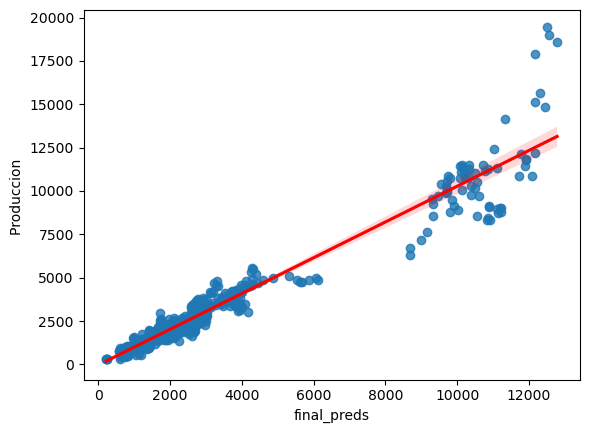

In [31]:
sns.regplot(data = results, x =  'final_preds', y = 'Produccion ', line_kws = {'color': 'red'})